## Isolation Test 2 - After Ceiling Plate had been installed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import nan
from pathlib import Path
from obspy import UTCDateTime, Stream

from andbro__get_timeaxis import __get_timeaxis
from andbro__load_FURT_stream import __load_furt_stream
from andbro__load_WROMY_stream import __load_wromy_stream

### Configurations

In [12]:
config = {}

config['channel'] = None

config['tbeg'] = UTCDateTime("2023-03-26 23:00")
config['tend'] = UTCDateTime("2023-03-30 00:00")

config['tbeg'] = UTCDateTime("2023-04-01 00:00")
config['tend'] = UTCDateTime("2023-04-30 00:00")


config['path_to_sds'] = f'/import/freenas-ffb-01-data/romy_archive/'

config['resample'] = 20

config['colors'] = {  'WS1':'darkgreen', 
                      'WS4':'purple', 
                      'WS5':'darkred',
                      'WS6':'darkblue',
                      'WS7':'darkorange',
                      'WS8':'darkcyan',
                      'WS9':'cyan',
                     }

### Methods

In [13]:
def __indicate_gaps_with_nan(df, config):
    
    differences = np.diff(df.totalSeconds, n=1)
    
    
    ## ______________
    
    sample_time_errors = [j for j in differences if j != config['resample']]

    if len(sample_time_errors) != 0:
        print(f"  -> ERROR: Found {len(sample_time_errors)} errors for the sampling time!\n")
    
    
    ## ______________
    
    gaps = [list(differences).index(k) for k in differences if k > 2*config['resample']] or []
    if gaps and gaps[0] in [0, 0.0]:
        gaps.pop(0)    
    del differences
    
    for x in gaps:
        fill_row = [i+config['resample'] if n not in [3,4,5] else np.nan for n, i in enumerate(df.iloc[x,:])]
        fill_row[0] = int(df.iloc[x,0])
        fill_row[1] = int(df.iloc[x,1])
        fill_row[2] = int(df.iloc[x,2])
        df.loc[x+0.5] = fill_row

    
    df = df.sort_index().reset_index(drop=True).convert_dtypes()

    print(f"  -> Marked {len(gaps)} gaps with NaN values!\n")
    
    return df

In [14]:
def __processing(data, config):
    
    filter_length = 10*config['resample']
    
    data.iloc[:,3:6] = data.iloc[:,3:6].rolling(filter_length).mean() 
    __reply(f"Filter: rooling mean {filter_length}!")
    
    data = data[data.index % config['resample'] == 0]
    __reply(f"Resampling: keep every {config['resample']}nth sample!")
    
    return data

### Load WROMY Data

In [15]:
furt = __load_furt_stream(config)

  0%|          | 0/30 [00:00<?, ?it/s]

/home/brotzer/anaconda3/lib/python3.7/site-packages/andbro__load_FURT_stream.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="coerce")


  -> File: FURT.WSX.D.030423.0000, does not exists!
Specified end: 2023-04-30T00:00:00.000000Z 
Trace end:     2023-04-30T00:00:00.000000Z


### Load WROMY Data

In [16]:
def __load_wromy_stream(path_to_sds, seed_id, tbeg, tend):
    
    '''
    
    reads WROMY data from tbeg to tend
    
    >>> __load_wromy_stream(path_to_sds, seed_id, tbeg, tend)
    
    '''

    from os.path import exists
    from pandas import date_range, read_csv, concat, DataFrame
    from tqdm.notebook import tqdm_notebook
    from obspy import Stream, UTCDateTime
    from numpy import nan, inf
    
    def __add_trace(seed_id, ch, tbeg, dat):

        from obspy import Trace, UTCDateTime
        from numpy import array
        from numpy.ma import masked_invalid

        net, sta, loc, cha = seed_id.split(".")

        tr = Trace()
        tr.stats.network = net
        tr.stats.station = 'WROMY'
        tr.stats.location = cha
        tr.stats.channel = str(ch)
        tr.stats.sampling_rate = 1.0
        tr.stats.starttime = UTCDateTime(tbeg)
        tr.data = masked_invalid(array(dat))

        return tr
    
    
    t1 = tbeg
    t2 = tend + 86410
    
    net, sta, loc, cha = seed_id.split(".")
    
    df = DataFrame()
    
    for n, date in enumerate(tqdm_notebook(date_range(t1.date, t2.date))):    
        doy = str(date.timetuple().tm_yday).rjust(3,"0")
        
#        path = f"/import/freenas-ffb-01-data/romy_archive/{date.year}/{net}/{sta}/{cha}.D/"
        path = f"{path_to_sds}{date.year}/{net}/{sta}/{cha}.D/"
        
        if not exists(path):
            print(f"Path: {path}, does not exists!")
            return

    
        fileName = f"BW.WROMY.{cha}.D.{date.year}.{doy}"

#         print(f'   reading {fileName} ...')

        try:
            df0 = read_csv(path+fileName)
            
            ## replace error indicating values (-9999, 999.9) with NaN values
            df0.replace(to_replace=-9999, value=nan, inplace=True)
            df0.replace(to_replace=999.9, value=nan, inplace=True)
            df0.replace(to_replace=inf, value=nan, inplace=True)
              
#             ## change time from in to 6 character string
            df0.iloc[:,2] = [str(ttt).rjust(6,"0") for ttt in df0.iloc[:,2]]
          
            if n == 1:
                df = df0
            else: 
                df = concat([df,df0])
        except:
            print(f"File: {fileName}, does not exists!")
       

    
    df.reset_index(inplace=True, drop=True)
    
    df_starttime = UTCDateTime(f"{df['Date'][0]} {df['Time (UTC)'][0]}")
    
    
    ## add columns with total seconds
    if 'Seconds' in df.columns:
        totalSeconds = df.Seconds + (df.Date - df.Date.iloc[0]) * 86400
        df['totalSeconds'] = totalSeconds
    
    st0 = Stream()
    st0 += __add_trace(seed_id, "LAT", df_starttime, df['Temperature (°C)'])
    st0 += __add_trace(seed_id, "LAP", df_starttime, df['Pressure (hPa)'])
    st0 += __add_trace(seed_id, "LAH", df_starttime, df['rel. Humidity (%)'])
        
        
    st0.trim(tbeg, tend)
    
    if len(st0) > 3:
        print(" -> split, interpolate, merge ...")
        st0.split().merge(fill_value="interpolate")

    
    print(f"Specified end: {tend} \nTrace end:     {st0.select(channel='LAT')[0].stats.endtime}")
    
    return st0

In [17]:
ws7 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS7", config['tbeg'], config['tend'])
ws8 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS8", config['tbeg'], config['tend'])
ws9 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS9", config['tbeg'], config['tend'])

  0%|          | 0/31 [00:00<?, ?it/s]

Specified end: 2023-04-30T00:00:00.000000Z 
Trace end:     2023-04-30T00:00:00.000000Z


  0%|          | 0/31 [00:00<?, ?it/s]

Specified end: 2023-04-30T00:00:00.000000Z 
Trace end:     2023-04-30T00:00:00.000000Z


  0%|          | 0/31 [00:00<?, ?it/s]

Specified end: 2023-04-30T00:00:00.000000Z 
Trace end:     2023-04-30T00:00:00.000000Z


### Plotting

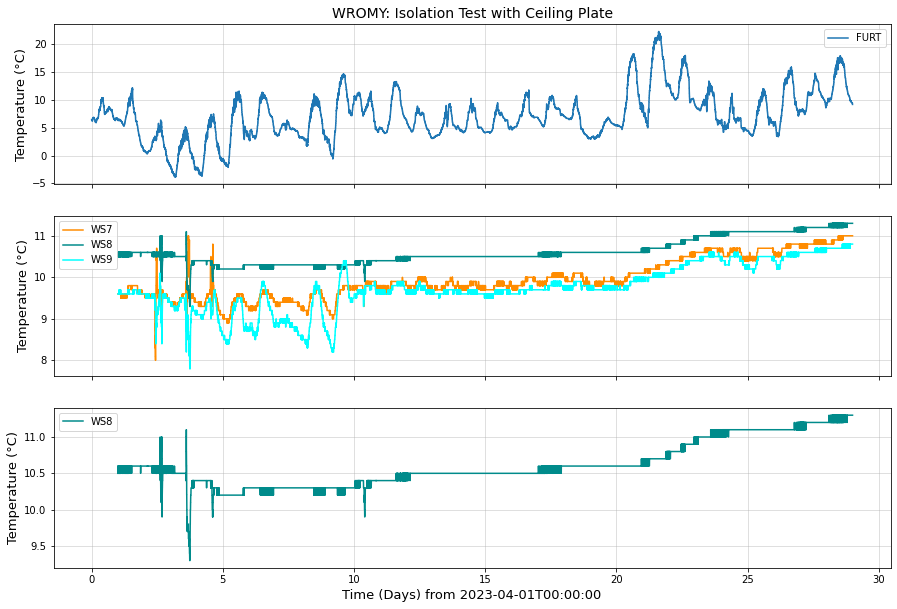

In [25]:
def __makeplot():
    
    N = 3
    font = 13

    fig, ax = plt.subplots(N, 1, figsize=(15,10), sharex=True)

    ref_time = config['tbeg']
    t_scale = 86400
    
    ax[0].plot(furt.select(channel="*T")[0].times(reftime=ref_time)/t_scale, 
               furt.select(channel="*T")[0].data, label="FURT")

    ax[1].plot(ws7.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               ws7.select(channel="*T")[0].data, c=config['colors']['WS7'], label="WS7")
    ax[1].plot(ws8.select(channel="*T")[0].times(reftime=ref_time)/t_scale, 
               ws8.select(channel="*T")[0].data, c=config['colors']['WS8'], label="WS8")
    ax[1].plot(ws9.select(channel="*T")[0].times(reftime=ref_time)/t_scale, 
               ws9.select(channel="*T")[0].data, c=config['colors']['WS9'], label="WS9")
    
    ax[2].plot(ws8.select(channel="*T")[0].times(reftime=ref_time)/t_scale, 
               ws8.select(channel="*T")[0].data, c=config['colors']['WS8'], label="WS8")
 
    ax[0].set_title("WROMY: Isolation Test with Ceiling Plate", fontsize=font+1)

    ax[0].set_ylabel("Temperature (°C)", fontsize=font)
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)
    ax[2].set_ylabel("Temperature (°C)", fontsize=font)
    ax[2].set_xlabel(f"Time (Days) from {str(ref_time).split('.')[0]}", fontsize=font)

    
    for n in range(N):
        ax[n].legend()
        ax[n].grid(alpha=0.5, zorder=-1)
        
    plt.show();
    return fig

fig = __makeplot()